## Area of Study Definition

### Code scope:
- Define network(s) and extract in format suitable for OD methods
- Define test sensors and time period of interest

In [1]:
import osmnx as ox
import pandas as pd
from shapely.geometry import box, Polygon, MultiPolygon, Point, LineString, mapping
from shapely.ops import transform
from functools import partial
import pyproj
import geopandas as gpd
import geojson
import matplotlib.pyplot as plt

#Below function from ChatGPT
#Get expanded network - method 1 km buffer
def expand_bbox(original_bbox, expansion_distance_km=5):
    # Create a Shapely geometry object for the original bounding box
    original_geometry = box(*original_bbox)

    # Define a function to project the geometry to a new coordinate reference system
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),  # WGS 84 coordinate reference system
        pyproj.Proj(proj='utm', zone=33, ellps='WGS84')  # Example: UTM Zone 33
    )

    # Project the original geometry to the new coordinate reference system
    projected_geometry = transform(project, original_geometry)

    # Calculate the expansion distance in the projected coordinate system
    expansion_distance_meters = expansion_distance_km * 1000

    # Expand the geometry by the specified distance
    expanded_geometry = projected_geometry.buffer(expansion_distance_meters)

    # Project the expanded geometry back to the original coordinate reference system
    expanded_geometry = transform(partial(pyproj.transform, pyproj.Proj(proj='utm', zone=33, ellps='WGS84'), pyproj.Proj(init='epsg:4326')), expanded_geometry)

    # Get the coordinates of the expanded bounding box
    expanded_bbox = expanded_geometry.bounds

    return expanded_bbox, expanded_geometry

In [2]:
# Get sensors
sensors = pd.read_csv('Data/midas_sensor_locations.csv')

#Get sensor distances
distance_df = pd.read_csv('Data/sensors_with_distances.csv', index_col=0)

sensors = sensors.merge(distance_df[['site ID','sp length']],left_on = 'site_ID',right_on = 'site ID', how='left').drop('site ID', axis=1)

# Define Route 1 (A20/M20) with closed network assumption

In [3]:
#Read in sensors for A20 route

with open('Data/route1_a20.csv', newline='') as f:
    a20_sensors = f.read().splitlines()
print(a20_sensors)

a20_sensor = sensors[sensors['site_ID'].isin(a20_sensors)]

a20_sensor = a20_sensor.sort_values('sp length')

['5892/1', '5889/1', 'A20/7113A', 'M20/7095A', 'M20/7076A', 'M20/7018A', 'M20/6913A', 'M20/6905A', 'M20/6868A', 'M20/6645A', 'M20/6590A', 'M20/6582A', 'M20/6576A', 'M20/6572A', 'M20/6570A', 'M20/6568A1', 'M20/6552A1', 'M20/6545A', 'M20/6547A1', 'M20/6540A', 'M20/6534A', 'M20/6538A', 'M20/6531A', 'M20/6526A', 'M20/6518A', 'M20/6520A', 'M20/6523A', 'M20/6514A', 'M20/6517A', 'M20/6506A', 'M20/6511A', 'M20/6501A', 'M20/6498A', 'M20/6481A', 'M20/6484A', 'M20/6487A', 'M20/6491A', 'M20/6494A', 'M20/6477A', 'M20/6460A', 'M20/6465A', 'M20/6468A', 'M20/6472A', 'M20/6476A', 'M20/6454A', 'M20/6404A']


In [4]:
# Get bounding box
max_y = a20_sensor['Latitude'].max()
min_y = a20_sensor['Latitude'].min()
max_x = a20_sensor['Longitude'].max()
min_x = a20_sensor['Longitude'].min()

bounding_box = box(min_x, min_y, max_x, max_y)

#Export box for vis
gpd.GeoSeries([bounding_box]).to_file('Data/Networks/route1/initial_bounding_box.geojson', driver='GeoJSON')

#Expand bbox by some small amount to expand beyond all sensors and capture contours in nearby road
original_bbox = (min_x, min_y, max_x, max_y)  # Replace with your original bounding box coordinates
expanded_bbox, expanded_geometry = expand_bbox(original_bbox, expansion_distance_km=0.5)
box_expanded = box(expanded_bbox[2],expanded_bbox[1],expanded_bbox[0],expanded_bbox[3])

#Export box for vis
gpd.GeoSeries([box_expanded]).to_file('Data/Networks/route1/expanded_bounding_box.geojson', driver='GeoJSON')

/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/

In [5]:
#Define line object between all sensors

point1 = Point(a20_sensor.iloc[0]['Longitude'],a20_sensor.iloc[0]['Latitude'])

line_objects = []
buffered_line_objects = []
for i,r, in a20_sensor[1:].iterrows():
    point2 = Point(r['Longitude'],r['Latitude'])
    sensor_line = LineString([point1,point2])
    line_objects.append(sensor_line)
    buffered_line_objects.append(sensor_line.buffer(0.009999))
    point1 = point2

# Create a FeatureCollection from the list of LineString objects
feature_collection = geojson.FeatureCollection([geojson.Feature(geometry=line) for line in line_objects])
# Convert the FeatureCollection to a GeoJSON string
geojson_string = geojson.dumps(feature_collection, indent=2)

# Save the GeoJSON string to a file
with open("Data/Networks/route1/sensor_to_sensor_lines.geojson", "w") as geojson_file:
    geojson_file.write(geojson_string)
    
# Convert buffered LineString objects to GeoJSON format
features = []
for buffered_line in buffered_line_objects:
    feature = geojson.Feature(geometry=mapping(buffered_line))
    features.append(feature)

# Create a FeatureCollection from the list of buffered LineString objects
feature_collection = geojson.FeatureCollection(features)

# Convert the FeatureCollection to a GeoJSON string
geojson_string = geojson.dumps(feature_collection, indent=2)

# Save the GeoJSON string to a file
with open("Data/Networks/route1/sensor_to_sensor_buffered_lines.geojson", "w") as geojson_file:
    geojson_file.write(geojson_string)
    
#Construct a polygon from line buffers

# Use unary_union to join the buffered LineString objects into a single polygon
A20_buffered_object = MultiPolygon(buffered_line_objects).buffer(0)  # Buffering with 0 effectively removes any small artifacts

# Convert the union polygon to GeoJSON format
feature = geojson.Feature(geometry=mapping(A20_buffered_object))

# Save the GeoJSON to a file
with open("Data/Networks/route1/A20_buffered_area.geojson", "w") as geojson_file:
    geojson_file.write(geojson.dumps(feature, indent=2))

In [169]:
# Extract route from OSMNX from buffer
#Get network for area just for pimary roads etc
cf = '["highway"~"motorway|motorway_link|primary|trunk"]'
G = ox.graph_from_polygon(A20_buffered_object, network_type='drive', custom_filter=cf, simplify=True)

node_attributes, edge_attributes = ox.graph_to_gdfs(G, nodes=True)

#Tidy Network
#Where there is multiple road types select 1 (at random)
road_types = []
for i in list(edge_attributes['highway']):
    if isinstance(i, str): 
        road_types.append(i)
    else:
        road_types.append(i[0])
edge_attributes['highway'] = road_types

#For edges with missing speed impute using mode
road_type_speed_limit = {}
for rtype in list(edge_attributes['highway'].value_counts().index):
    road_type_speed_limit[rtype] = edge_attributes[edge_attributes['highway'] == rtype]['maxspeed'].mode().values[0]

#Where speed missing or multuple, take from dict
speed = []
for i,r in edge_attributes.iterrows():
    #String case
    if isinstance(r['maxspeed'], str):
        speed.append(int("".join(filter(str.isdigit, r['maxspeed']))))
    #List case
    else:
        speed.append(int("".join(filter(str.isdigit, road_type_speed_limit[r['highway']]))))

edge_attributes['speed'] = speed

In [29]:
edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes[['highway','speed','geometry']], crs="EPSG:4326", geometry=edge_attributes['geometry'])
edge_attributes_gdf.to_file('Data/Networks/route1/road_network_in_buffer.geojson', driver='GeoJSON')

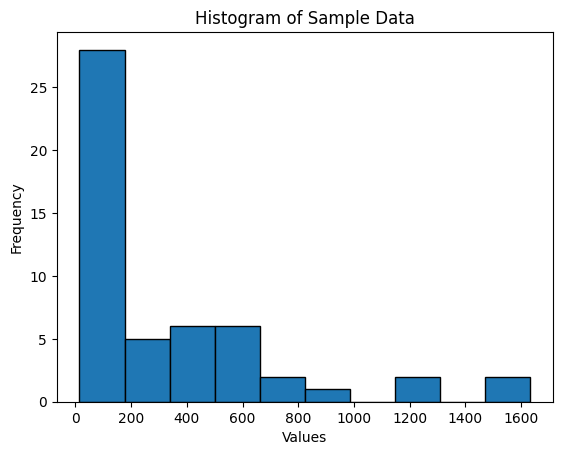

In [68]:
# Associate sensors to network

#Get sensor nearest nodes

sensor_nearest_node, distances = ox.distance.nearest_nodes(G, list(a20_sensor['Longitude']), list(a20_sensor['Latitude']), return_dist=True)

# Plotting the histogram
plt.hist(distances, bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sample Data')
plt.show()

In [49]:
snapped_nodes_dist = pd.DataFrame()

snapped_nodes_dist['nodeID'] = sensor_nearest_node
snapped_nodes_dist['dist'] = distances
snapped_nodes_dist = snapped_nodes_dist.set_index('nodeID')

snapped_nodes = node_attributes.loc[sensor_nearest_node]
snapped_nodes['distance'] = snapped_nodes_dist['dist']

sensor_to_node_gdf = gpd.GeoDataFrame(snapped_nodes[['geometry','distance']], crs="EPSG:4326", geometry=snapped_nodes['geometry'])
sensor_to_node_gdf.to_file('Data/Networks/route1/sensors_snapped_to_network.geojson', driver='GeoJSON')

In [ ]:
# Create artificial nodes at each sensor point

In [13]:
sensor_points = []
for i,r in a20_sensor.iterrows():
    sensor_points.append(Point(r['Longitude'],r['Latitude']))


In [73]:
for sensor_point in sensor_points:
    # Find the edge containing the sensor point
    for edge in G.edges():
        u, v = edge
        if sensor_point in [u, v]:
            print('edge found')
            # Split the edge at the sensor point
            G.remove_edge(u, v)
            G.add_edge(u, sensor_point)
            G.add_edge(sensor_point, v)

In [ ]:
#Next Steps

#Get nearest edge
#Split edge as per method above

In [9]:
sensor_nearest_edges, distances = ox.distance.nearest_edges(G, list(a20_sensor['Longitude']), list(a20_sensor['Latitude']), interpolate=None, return_dist=True)

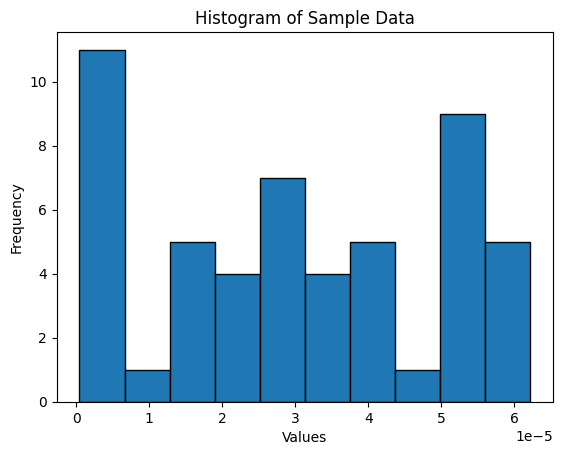

In [10]:
# Plotting the histogram
plt.hist(distances, bins=10, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sample Data')
plt.show()

In [156]:
from shapely.ops import nearest_points
from shapely.ops import split, snap
from sklearn.neighbors import NearestNeighbors
from pyproj import Proj, Transformer
import shapely.ops as sp_ops

In [170]:
for sens_ind in range(len(sensor_points)):
    #Get point
    sensor_point = sensor_points[sens_ind]

    #Get edge
    edge = G.edges[sensor_nearest_edges[sens_ind][0],sensor_nearest_edges[sens_ind][1],0]
    print(edge)

    #Edge Geometry
    edge_geom = edge['geometry']

    line_coords = list(edge_geom.coords)

    # Flatten the coordinates for use with NearestNeighbors
    X = [(x, y) for x, y in line_coords]
    # Fit a NearestNeighbors model
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
    # Query the model with the coordinates of the Point
    query_result = nn_model.kneighbors([[sensor_point.x, sensor_point.y]])
    # Get the index of the nearest point on the LineString
    nearest_point_index = query_result[1][0][0]
    # Extract coordinates of the nearest point on the LineString
    nearest_coordinates = line_coords[nearest_point_index]

    # Split edge geometry at nearest point
    split_line = split(edge_geom, Point(nearest_coordinates))

    #Get new geometries
    segments = [feature for feature in split_line.geoms]
    gdf_segments = gpd.GeoDataFrame(list(range(len(segments))), geometry=segments)
    gdf_segments.columns = ['index', 'geometry']

    #Capture edge attributes
    edge_attrs = G[sensor_nearest_edges[sens_ind][0]][sensor_nearest_edges[sens_ind][1]][0]

    #Remove edge
    G.remove_edge(sensor_nearest_edges[sens_ind][0],sensor_nearest_edges[sens_ind][1],0)

    #Add new edge with original features
    G.add_edge(sensor_nearest_edges[sens_ind][0], sensor_point, 0, **{**edge_attrs})

    #Update geometry
    G[sensor_nearest_edges[sens_ind][0]][sensor_point][0]['geometry'] = gdf_segments.iloc[0]['geometry']

    #Calculate new length
    # Create a GeoDataFrame with the LineString
    gdf = gpd.GeoDataFrame(geometry=[gdf_segments.iloc[0]['geometry']]).set_crs('EPSG:4326')
    # Convert the CRS of the GeoDataFrame (and the LineString within it)
    gdf = gdf.to_crs('EPSG:32633')

    G[sensor_nearest_edges[sens_ind][0]][sensor_point][0]['length'] = gdf.geometry.iloc[0].length

    #Add new edge with original features
    G.add_edge(sensor_point,sensor_nearest_edges[sens_ind][0], 0, **{**edge_attrs})

    #Update geometry
    G[sensor_point][sensor_nearest_edges[sens_ind][0]][0]['geometry'] = gdf_segments.iloc[1]['geometry']

    #Calculate new length
    # Create a GeoDataFrame with the LineString
    gdf = gpd.GeoDataFrame(geometry=[gdf_segments.iloc[1]['geometry']]).set_crs('EPSG:4326')
    # Convert the CRS of the GeoDataFrame (and the LineString within it)
    gdf = gdf.to_crs('EPSG:32633')

    G[sensor_point][sensor_nearest_edges[sens_ind][0]][0]['length'] = gdf.geometry.iloc[0].length

{'osmid': 1234047609, 'oneway': True, 'lanes': '2', 'ref': 'A20', 'name': 'Townwall Street', 'highway': 'trunk', 'maxspeed': '40 mph', 'access': 'yes', 'reversed': False, 'length': 624.0120000000001, 'geometry': <LINESTRING (1.318 51.125, 1.319 51.125, 1.319 51.125, 1.319 51.125, 1.32 51...>}
{'osmid': [178272608, 1126726196, 1126726197, 45776966], 'oneway': True, 'lanes': '2', 'ref': 'A20', 'highway': 'trunk', 'maxspeed': ['70 mph', '40 mph'], 'access': 'yes', 'reversed': False, 'length': 4121.742000000001, 'geometry': <LINESTRING (1.247 51.104, 1.248 51.104, 1.25 51.104, 1.252 51.104, 1.254 51...>}
{'osmid': [1126582504, 933310, 1126582503], 'oneway': True, 'lanes': '2', 'ref': 'A20', 'highway': 'trunk', 'maxspeed': '70 mph', 'reversed': False, 'length': 652.408, 'geometry': <LINESTRING (1.17 51.104, 1.171 51.104, 1.172 51.105, 1.172 51.105, 1.172 51...>}
{'osmid': 22586918, 'oneway': True, 'lanes': '2', 'ref': 'M20', 'highway': 'motorway', 'maxspeed': '70 mph', 'reversed': False, 'l

KeyError: 307639

In [ ]:
#TOMORROW

#Update process to reassign nodes in "nearest edge" list when new edges added

# Define Route 2 with closed network assumption

# Define Route 3 open network connecting major routes to Dover